In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.special as ss
import scipy.integrate as si
import scipy.optimize as so
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.numpy.linalg as jnl
from jax.config import config
config.update("jax_enable_x64", True)

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

<h1>Forward Problem</h1>

In [2]:
# size of spatial domain
L = 15.0  # originally 10, increased by 50%
# number of real space grid points (for plotting)
numx = 1025
# real space grid points (for plotting)
xvec = np.linspace(-L, L, numx)

# number of Fourier basis functions
# n = -numF to n = numF
numfour = 32  # 32

# matrix for converting Fourier representation to real space
fournvec = np.arange(-numfour, numfour + 1) # fournvec=-nfb,...,0,...,nfb
fourtox = np.exp(1j * np.pi * np.outer(fournvec, xvec) / L) / np.sqrt(2 * L)
print('Shape fourtox:', fourtox.shape)

Shape fourtox: (65, 1025)


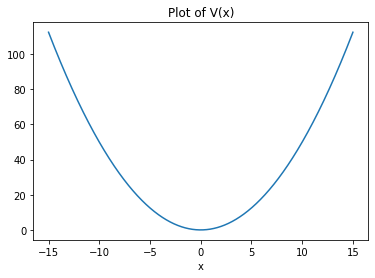

In [3]:
def v(z):
    # harmonic oscillator potential (should be exact for Chebyshev)
    return 0.5 * z**2
    # symmetric double well potential
    # return 2.5e-3 * (z**2 - 25)**2
    # asymmetric double well potential
    # c0 = 4.35; c1 = 9.40e-1; c2 = -3.56e-1; c3 = -4.66e-2
    # c4 = 1.46e-2; c5 = 6.76e-4; c6 = -1.26e-4; c7 = -5.43e-6
    # c8 = 4.12e-7; c9 = 1.65e-8
    # x = z + 0.8
    # return 0.5 * (c0 + c1*x + c2*x**2 + c3*x**3 + c4*x**4 + c5*x**5 + c6*x**6 + c7*x**7 + c8*x**8 + c9*x**9)
    # non-polynomial potentials
    # return np.sin(0.4 * z - 1)
    # return np.sin((0.5 * z)**2)
    # return 15 * (-np.cos(z) + np.sin((0.5 * z)**2 - 0.2 * z))
    # soft coulomb potential
    # return -1 / np.sqrt(z**2 + 0.25)

# compute true potential on real space grid for plotting
vxvec = v(xvec)

# plot true potential
plt.plot(xvec, vxvec)
plt.title('Plot of V(x)')
plt.xlabel('x')
plt.show()

In [4]:
# compute the potential operator matrix

vtoeptrue = []
for thisfourn in range(2 * numfour + 1):
    def intgrnd(x):
        return v(x) * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    vtoeptrue.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

vtoeptrue = jnp.array(vtoeptrue)

vmattrue = sl.toeplitz(r=vtoeptrue, c=np.conj(vtoeptrue))

print('Shape vmattrue:', vmattrue.shape)

Shape vmattrue: (65, 65)


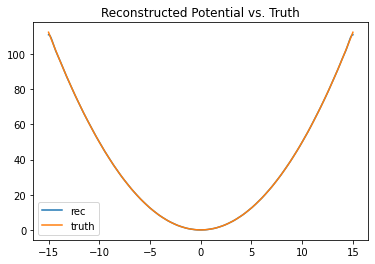

0.012198398680964392


In [5]:
# reconstruct the real space potential from the potential
# operator matrix

# at this point, "vtoeptrue" contains Fourier coefficients
# for modes 0, ..., 2*N
# let us convert this into information on modes -N, ..., N
# also we need a slight renormalization to make this a Fourier
# coefficient
# with respect to our ***orthonormal*** Fourier basis
vfour = np.sqrt(2*L)*np.concatenate([np.conjugate(np.flipud(vtoeptrue[1:(numfour + 1)])), vtoeptrue[:(numfour + 1)]])
vrecon = vfour @ fourtox

plt.plot(xvec, np.real(vfour @ fourtox), label='rec')
plt.plot(xvec, vxvec, label='truth')
plt.title('Reconstructed Potential vs. Truth')
plt.legend()
plt.show()

print(np.mean(np.square(np.abs(vrecon - vxvec))))

In [6]:
# define initial states and transform to Fourier basis

def psi0(x):
    return 10 * np.exp(-(x + 3)**2 / 4) * (2.0 / np.pi)**0.25
    # return np.exp(-(x - 3)**2 / 4) * (2.0 / np.pi)**0.25
    # return np.exp(-(x - 11)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-(x + 11)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-x**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x - 6)/4)**2) * (2.0 / np.pi)**0.25
    # a weird non-symmetric wavefunction
    # return np.abs(np.sin((0.15*x - 0.5)**2))
    # return np.exp(-((x + 6)/4)**2) * (2.0 / np.pi)**0.25


# function for normalizing initial wave functions and transforming them to the Fourier representation
def mka0(psi0fn):
    # compute psi0 normalization term
    psi0fn_prob_intgrnd = lambda x: np.abs(psi0fn(x)) ** 2
    psi0fn_norm = np.sqrt(si.quad(psi0fn_prob_intgrnd, -L, L)[0])

    # normalized psi function (for integration)
    norm_psi0fn = lambda x: psi0fn(x) / psi0fn_norm

    # compute the Fourier representation of psi0fn
    a0raw = []
    for thisfourn in range (numfour + 1):
        def intgrnd(x):
            return norm_psi0fn(x) * np.exp(-1j * np.pi * thisfourn * x / L) / np.sqrt(2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        a0raw.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

    a0 = np.concatenate([np.conjugate(np.flipud(a0raw[1:])), a0raw])

    a0 = jnp.array(a0)

    normpsi0x = norm_psi0fn(xvec)

    return a0, normpsi0x


l2 error psi0: 4.200734367144785e-15
l-infinity error psi0: 5.551115123125783e-16


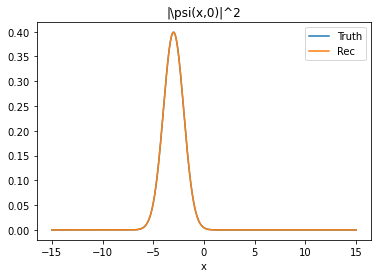

In [7]:
# compute vector of initial states

a0, normpsi0x = mka0(psi0)
normpsi0recx = a0 @ fourtox

# check if reconstructed Fourier representation is close to truth
print(f'l2 error psi0:', nl.norm(normpsi0x - normpsi0recx))
print(f'l-infinity error psi0:', np.max(np.abs(normpsi0x - normpsi0recx)))
# plot |\psi(x,0)|^2
plt.plot(xvec, np.abs(normpsi0x) ** 2, label=f"Truth")
plt.plot(xvec, np.abs(normpsi0recx) ** 2, label=f"Rec")
plt.title('|\psi(x,0)|^2')
plt.xlabel('x')
plt.legend()
plt.show()

---
**Forward Propagation**

In [8]:
# Eigendecomposition of true Hamiltonian

# kinetic operator in the Fourier representation
# (this is constant for a given system)
kmat = np.diag(np.arange(-numfour, numfour + 1) ** 2 * np.pi ** 2 / (2 * L ** 2))

# Hamiltonian operator in the Fourier representation
hmattrue = kmat + vmattrue

# check if the Hamiltonian matrix is Hermitian
print('hmattrue Hermitian check (should be close to zero):', nl.norm(hmattrue - hmattrue.T.conj()), sep='\n')

# eigen-decomposition of the Hamiltonian matrix
spctrue, stttrue = jnl.eigh(hmattrue)

# check if the decomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('hmattrue diagonalized check (should be close to zero):', nl.norm(hmattrue @ stttrue - stttrue @ np.diag(spctrue)), sep='\n')

# check if the eigenstates are unitary
print('stttrue unitary check (should be close to zero):', nl.norm(stttrue @ stttrue.T.conj() - np.eye(2 * numfour + 1)), sep='\n')

hmattrue Hermitian check (should be close to zero):
0.0
hmattrue diagonalized check (should be close to zero):
9.770256348336455e-13
stttrue unitary check (should be close to zero):
1.9640078542463594e-14


In [9]:
# Propagate

# set time-step size
dt = 1e-2

# set number of time steps
# trajectory length is numts + 1 (initial state + numts steps)
numts = 20  # 40  # 100

# compute propagator matrix
propatrue = stttrue @ jnp.diag(jnp.exp(-1j * spctrue * dt)) @ stttrue.conj().T


# propagate system starting from initial "a" state
amattrue = [a0.copy()]
for i in range(numts):
    amattrue.append(propatrue @ amattrue[-1])

amattrue = jnp.array(amattrue)

print('Shape amattrue:', amattrue.shape)

print('Done propagating')

Shape amattrue: (21, 65)
Done propagating


In [10]:
# check if system's state remains normalized for the propagation

psimattruevec = amattrue @ fourtox
print('Shape psimattrue:', psimattruevec.shape)

probmattruevec = np.abs(psimattruevec) ** 2
print('Shape probmattrue:', probmattruevec.shape)

normmattruevec = si.trapezoid(probmattruevec, xvec)
print('Shape normmattrue:', normmattruevec.shape)

# average deviation from 1
np.mean(np.abs(normmattruevec - 1.0))

Shape psimattrue: (21, 1025)
Shape probmattrue: (21, 1025)
Shape normmattrue: (21,)


3.0890633966118046e-14

---
<h1>Inverse Problem</h1>

In [11]:
# used for constructing Toeplitz matrix from a vector setup
# like jnp.concatenate([jnp.flipud(row.conj()), row[1:]])

numtoepelms = 2 * numfour + 1
aa = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
bb = [np.arange(numtoepelms - 1, 2 * numtoepelms - 1)]
toepindxmat = np.array(aa + bb)
print(toepindxmat.shape)

(65, 65)


In [12]:
# check if index method makes same vmat
# should be close to 0

print(nl.norm(vmattrue - np.concatenate([np.flipud(np.conj(vtoeptrue)), vtoeptrue[1:]])[toepindxmat]))

0.0


In [13]:
# make |\psi(t)|^2 training data in the Fourier representation

# compute "beta" from "a"
# correlate only works with 1D vectors
betamat = []
for thisavec in amattrue:
    betamat.append(jnp.correlate(thisavec, thisavec, 'same'))

betamat = jnp.array(betamat) / jnp.sqrt(2 * L)

print('Shape betamat:', betamat.shape)
print('Shape probmattruevec:', probmattruevec.shape)

probmatrec = betamat @ fourtox
print('Shape betamat @ fourtox:', probmatrec.shape)

print('l2 error betamat:', jnl.norm(probmattruevec - probmatrec))
print('l-inf error betamat:', jnp.max(jnp.abs((probmattruevec - probmatrec))))

Shape betamat: (21, 65)
Shape probmattruevec: (21, 1025)
Shape betamat @ fourtox: (21, 1025)
l2 error betamat: 4.051107722171325e-10
l-inf error betamat: 7.498113241411991e-12


In [14]:
# objective function

def probobj(theta, verbose=False):
    # theta is a vector containing the concatenation
    # of real and imaginary parts of vmat
    # its size should be 2 * numtoepelms - 1 = 4 * numfour + 1

    # to use theta we need to first recombine the real
    # and imaginary parts into a vector of complex values
    vtoephatR = theta[:numtoepelms]
    vtoephatI = jnp.concatenate((jnp.array([0.0]), theta[numtoepelms:]))
    # vtoephatI = theta[numtoepelms:]
    vtoephat = vtoephatR + 1j * vtoephatI

    if verbose:
        print('l2 error vtoephat:', jnl.norm(vtoephat - vtoeptrue))

    # construct vmathat from complex toeplitz vector
    vmathat = jnp.concatenate([jnp.flipud(jnp.conj(vtoephat)), vtoephat[1:]])[toepindxmat]

    # Construct Hamiltonian matrix
    hmathat = kmat + vmathat

    if verbose:
        # check if hmat is Hermitian
        print('hmat hermitian? (should be close to 0):', jnl.norm(hmathat - hmathat.T.conj()), sep='\n')
        print('l2 error hmat:', jnl.norm(hmathat - hmattrue))

    # eigen-decomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hmathat)

    if verbose:
        # check if the decomposition diagonalizes hmat
        # if this is close to zero then
        # hmat = states @ np.diag(spec) @ np.conj(states).T
        print('hmathat diagonalized? (should be close to 0):', jnl.norm(hmathat @ stthat - stthat @ jnp.diag(spchat)), sep='\n')

        # check if stt is unitary
        print('stthat unitary? (should be close to 0):', jnl.norm(stthat @ stthat.T.conj() - jnp.eye(2 * numfour + 1)), sep='\n')

        print('l2 error spchat:', jnl.norm(spchat - spctrue))
        print('l2 error stthat:', jnl.norm(stthat - stttrue))

        print('|| vmattrue - vmathat || = ', jnl.norm(vmattrue - vmathat))

    # compute propagator matrix
    propahat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T

    # propagate system starting from initial "a" state
    thisahat = a0.copy()
    rhomat = [jnp.correlate(a0, a0, 'same') / jnp.sqrt(2 * L)]
    for i in range(numts):
        # propagate the system one time-step
        thisahat = (propahat @ thisahat)

        # calculate the amp^2
        rhomat.append(jnp.correlate(thisahat, thisahat, 'same') / jnp.sqrt(2 * L))

    # compute objective functions
    tempresid = jnp.array(rhomat) - betamat
    rtnobj = 0.5 * jnp.sum(jnp.abs(tempresid)**2)

    return rtnobj

In [54]:
# true potential in a form that can be tested in objective

vtoeptruecat = jnp.concatenate((jnp.real(vtoeptrue), jnp.imag(vtoeptrue[1:])))

print('Shape vfourcat:', vtoeptruecat.shape)

print(nl.norm(vtoeptruecat[:numtoepelms] + 1j * jnp.concatenate((jnp.array([0.0]), vtoeptruecat[numtoepelms:])) - vtoeptrue))

Shape vfourcat: (129,)
0.0


In [16]:
# check objective with true potential
print('Objective:', probobj(vtoeptruecat, verbose=True))

l2 error vtoephat: 0.0
hmat hermitian? (should be close to 0):
0.0
l2 error hmat: 0.0
hmathat diagonalized? (should be close to 0):
9.770256348336455e-13
stthat unitary? (should be close to 0):
1.9640078542463594e-14
l2 error spchat: 0.0
l2 error stthat: 0.0
|| vmattrue - vmathat || =  0.0
Objective: 0.0


In [17]:
# jit probobj
jitprobobj = jax.jit(probobj)

In [18]:
# complie and test jitprobobj
print(jitprobobj(vtoeptruecat))

3.0764636262633225e-32


In [19]:
# JAX grad of the objective
gradprobobj = jax.jit(jax.grad(jitprobobj))

In [20]:
# check grad of objective with true potential
print(jnl.norm(gradprobobj(vtoeptruecat)))

1.1129140354822036e-17


---
<h1>Adjoint Method</h1>

\begin{equation*}
%
\rho_j^r
& = \frac{1}{\sqrt{2 L}} \sum_{k=-F}^F a_{k + j}^r \overline{a}_k^r
%
\end{equation*}

``rho = [jnp.correlate(thisa0, thisa0, 'same') / jnp.sqrt(2 * L)]``


\begin{equation*}
%
M_{j, \ell}^r = \overline{a_{\ell - j}^r}
%
\end{equation*}

\begin{equation*}
%
P_{j, \ell}^r = a_{\ell + j}^r
%
\end{equation*}

In [21]:
def mk_M_and_P(avec):
    halflen = len(avec) // 2
    padavec = jnp.concatenate((jnp.zeros(halflen), jnp.array(avec), jnp.zeros(halflen)))

    rawmat = []
    for j in range(2 * halflen + 1):
        rawmat.append(padavec[2 * halflen - j:4 * halflen + 1 - j])

    Mmat = jnp.conjugate(jnp.array(rawmat))
    Pmat = jnp.flipud(jnp.array(rawmat))

    return Mmat, Pmat

In [22]:
jit_mk_M_and_P = jax.jit(mk_M_and_P)

testM, testP = jit_mk_M_and_P([1, 2, 3, 4, 5])
# testM, testP = jit_mk_M_and_P([1 + 0.5j, 2 + 1.0j, 3 + 1.5j, 4 + 2.0j, 5 + 2.5j])
print('M:', testM, 'P:', testP, sep='\n')

# print(testM + testP)
print(np.sum(testM + testP, axis=1))

M:
[[3. 4. 5. 0. 0.]
 [2. 3. 4. 5. 0.]
 [1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4.]
 [0. 0. 1. 2. 3.]]
P:
[[0. 0. 1. 2. 3.]
 [0. 1. 2. 3. 4.]
 [1. 2. 3. 4. 5.]
 [2. 3. 4. 5. 0.]
 [3. 4. 5. 0. 0.]]
[18. 24. 30. 24. 18.]


---

In [23]:
test = np.array([[[1, 2],[3, 4]], [[5, 6],[7, 8]]])
print(test)
print(np.transpose(test, axes=(0, 2, 1)))
print(np.flipud(test))

[[[1 2]
  [3 4]]

 [[5 6]
  [7 8]]]
[[[1 3]
  [2 4]]

 [[5 7]
  [6 8]]]
[[[5 6]
  [7 8]]

 [[1 2]
  [3 4]]]


---

\begin{equation*}
%
\lambda^T
= \frac{1}{\sqrt{2 L}} \left[ \left( M^T \right)^\dagger \left( \rho^T - \beta^T \right) + \overline{\left( P^T \right)^\dagger \left( \rho^T - \beta^T \right)} \right]
%
\end{equation*}

\begin{equation*}
%
\lambda^r
= \frac{1}{\sqrt{2 L}} \left[ \left( M^r \right)^\dagger \left( \rho^r - \beta^r \right) + \overline{\left( P^r \right)^\dagger \left( \rho^r - \beta^r \right)} \right] +
\left[ e^{ -i \hat{H} \Delta t} \right]^\dagger \lambda^{r+1}
%
\end{equation*}

\begin{equation*}
%
\frac{\partial L}{\partial \hat{\theta}}
= \mathfrak{R}
\left< \lambda^{r+1},
\left. \frac{\partial}{\partial \Upsilon} e^\Upsilon \right|_{\Upsilon = -i \hat{H} \Delta t}
\left( -i \Delta t \right) \hat{a}^r
\right>
= \mathfrak{R} - \sum_{r=0}^{T-1}
\left( \lambda^{r+1} \right)^\dagger
\left. \frac{\partial}{\partial \Upsilon} e^\Upsilon \right|_{\Upsilon = -i \hat{H} \Delta t}
\left( -i \Delta t \right) \hat{a}^r
%
\end{equation*}

In [49]:
def adjgrads(theta):
    # to use theta we need to first recombine the real
    # and imaginary parts into a vector of complex values
    vtoephatR = theta[:numtoepelms]
    vtoephatI = jnp.concatenate((jnp.array([0.0]), theta[numtoepelms:]))
    # vtoephatI = theta[numtoepelms:]
    vtoephat = vtoephatR + 1j * vtoephatI
    # print('Shape vtoephat:', vtoephat.shape)

    # construct vmathat from complex toeplitz vector
    vmathat = jnp.concatenate([jnp.flipud(jnp.conj(vtoephat)), vtoephat[1:]])[toepindxmat]

    # Construct Hamiltonian matrix
    hmathat = kmat + vmathat

    # eigen-decomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hmathat)

    # compute propagator matrix
    propahat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T
    proplam = jnp.transpose(jnp.conjugate(propahat))

    # propagate system starting from initial "a" state
    rhomat = [jnp.correlate(a0, a0, 'same') / jnp.sqrt(2 * L)]
    partlammat = [jnp.zeros(numtoepelms, dtype=complex)]
    ahatmat =[a0.copy()]
    for i in range(numts):
        # propagate the system one time-step
        ahatmat.append(propahat @ ahatmat[-1])

        # calculate the amp^2
        rhomat.append(jnp.correlate(ahatmat[-1], ahatmat[-1], 'same') / jnp.sqrt(2 * L))

        # compute error of current time step
        err = rhomat[-1] - betamat[i+1]

        # compute M and P matrix for lambda mat
        thisMmat, thisPmat = jit_mk_M_and_P(ahatmat[-1])

        # compute part of lambda mat
        # ( 1 / \sqrt{2 L} ) * [ ( M^r )^\dagger * ( \rho^r - \beta^r )
        # + \overline{( P^r )^\dagger * ( \rho^r - \beta^r )} ]
        partlammat.append((thisMmat.conj().T @ err + (thisPmat.conj().T @ err).conj()) / jnp.sqrt(2 * L))

    ahatmat = jnp.array(ahatmat)

    # build lammat backwards then flip at the end
    lammat = [partlammat[-1]]
    for i in range(2, numts + 2):
        lammat.append(partlammat[-i] + proplam @ lammat[-1])

    lammat = jnp.flipud(jnp.array(lammat))

    #######################################
    # HSB code. computes ahatmat, rhohatmat and lambda mat,
    # like the above code
    #######################################
    # # propagate system starting from initial "a" state
    # rhomat = [jnp.correlate(a0, a0, 'same') / jnp.sqrt(2 * L)]
    # ahatmat =[a0.copy()]
    # for i in range(numts):
    #     # propagate the system one time-step
    #     ahatmat.append(propahat @ ahatmat[-1])
    #
    #     # calculate the amp^2
    #     rhomat.append(jnp.correlate(ahatmat[-1], ahatmat[-1], 'same') / jnp.sqrt(2 * L))
    #
    # ahatmat = jnp.array(ahatmat)
    # rhomat = jnp.array(rhomat)
    # err = rhomat - betamat
    #
    # # **mathematically** each lambda is a column vector
    # #
    # # \langle \lambda^{k+1}, a^{k+1} - F a^{k} \rangle
    # # \langle \lambda^{k+1}, \delta a^{k+1} - F \delta a^{k} \rangle
    # # \langle \lambda^{k+1}, \delta a^{k+1} \rangle - \langle \lambda^{k+1}, F \delta a^{k} \rangle
    # # \langle \lambda^{k+1}, \delta a^{k+1} \rangle - \langle F^\dagger \lambda^{k+1}, \delta a^{k} \rangle
    #
    # # < v, A w > = v^\dagger A w = (A^\dagger v)^\dagger w = < A^\dagger v, w >
    #
    # build lammat backwards then flip at the end
    # thisMmat, thisPmat = jit_mk_M_and_P(ahatmat[numts])
    # lamfinal = thisMmat.conj().T @ err[numts] + (thisPmat.conj().T @ err[numts]).conj()
    # lamfinal /= jnp.sqrt(2*L)
    # lammat = [lamfinal]
    # for i in range(1, numts+1):
    #     k = numts - i
    #     thisMmat, thisPmat = jit_mk_M_and_P(ahatmat[k])
    #     thislam = thisMmat.conj().T @ err[k] + (thisPmat.conj().T @ err[k]).conj()
    #     thislam /= jnp.sqrt(2*L)
    #     lammat.append(thislam + proplam @ lammat[i-1])
    #
    # lammat = jnp.flipud(jnp.array(lammat))



    #######################################
    # the remainder of this function is for computing the
    # gradient of the exponential matrix
    #######################################

    offdiagmask = jnp.ones((numtoepelms, numtoepelms)) - jnp.eye(numtoepelms)
    expspec = jnp.exp(-1j * dt * spchat)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(spchat, spchat)
    denom = offdiagmask * (-1j * dt) * (s1 - s2) + jnp.eye(numtoepelms)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)

    myeye = jnp.eye(numtoepelms)
    wsR = jnp.hstack([jnp.fliplr(myeye), myeye[:,1:]]).T
    ctrmatsR = wsR[toepindxmat]
    prederivamatR = jnp.einsum('ij,jkm,kl->ilm', stthat.conj().T, ctrmatsR,stthat)
    derivamatR = prederivamatR * jnp.expand_dims(mask,2)
    alldmatreal = -1j * dt * jnp.einsum('ij,jkm,kl->mil',stthat, derivamatR, stthat.conj().T)

    wsI = 1.0j * jnp.hstack([-jnp.fliplr(myeye), myeye[:,1:]])
    wsI = wsI[1:,:]
    wsI = wsI.T
    ctrmatsI = wsI[toepindxmat]
    prederivamatI = jnp.einsum('ij,jkm,kl->ilm',stthat.conj().T, ctrmatsI, stthat)
    derivamatI = prederivamatI * jnp.expand_dims(mask, 2)
    alldmatimag = -1j * dt * jnp.einsum('ij,jkm,kl->mil',stthat, derivamatI, stthat.conj().T)

    alldmat = jnp.vstack([alldmatreal, alldmatimag])

    # compute all entries of the gradient at once
    gradients = jnp.real(jnp.einsum('ij,ajk,ik->a', jnp.conj(lammat[1:,:]), alldmat, ahatmat[:-1,:]))

    return gradients

In [53]:
print(adjgrads(vtoeptruecat))
print(adjgrads(vtoeptruecat).shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(129,)


---
**Check grads with randomly generated input**

In [52]:
for i in range(50):
    thetarnd = 0.2 * np.random.default_rng().normal(size=2 * numtoepelms - 1)
    thisadjgrads = adjgrads(thetarnd)
    thisjaxgrads = gradprobobj(thetarnd)
    print(nl.norm(thisadjgrads - thisjaxgrads))

1.2303517686030683e-14
3.3470835831125826e-13
6.540344670630761e-14
1.2370861356307738e-14
8.218430409223096e-15
4.496482546858731e-14
1.0595701803134387e-14
4.6173488585901065e-14
6.466823805128262e-15
1.9691726349862236e-14
3.190427255001245e-15
2.966606411515394e-14
4.946803354840203e-15
5.777860404504867e-14
2.518832371587505e-14
3.530917206875752e-14
1.3839549265794262e-14
1.3459106725384115e-13
1.6522617559011627e-14
1.2860316836516175e-14
1.9843758974807136e-14
1.508725166698954e-14
3.163731441947576e-14
2.007357160669604e-14
8.680501439948793e-14
1.363198322905675e-14
2.354565548608969e-12
1.2467860458630026e-13
4.326766312339289e-14
3.379407228677722e-14
1.1235058489678682e-14
8.55650201059911e-15
8.41171808172438e-14
9.647481905191916e-15
5.3904594341838616e-15
6.326803483079479e-14
8.510149492109218e-14
6.98220025003992e-15
4.62283820611487e-14
8.682410272783294e-14
3.4624021061611795e-14
1.0403630755905822e-13
2.954228999989748e-13
2.0159921298998154e-14
4.3957484894407706e